# Fall 2024 Data Science Track: Week 5 - Unsupervised Learning

## Packages, Packages, Packages!

Import *all* the things here! You need: `matplotlib`, `networkx`, `numpy`, and `pandas`―and also `ast.literal_eval` to correctly deserialize two columns in the `rules.tsv.xz` file.

If you got more stuff you want to use, add them here too. 🙂

In [124]:
# Don’t worry about this. This is needed to interpret the Python code that is embedded in the data set. You only need it literally in the very next code cell and nowhere else. 
from ast import literal_eval

# The rest is just the stuff from the lecture.
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# Instacart Association Rules

## Introduction

With the packages out of the way, now you will be working with the Instacart association rules data set, mined from the [Instacart Market Basket Analysis data set](https://www.kaggle.com/c/instacart-market-basket-analysis/data) on Kaggle. [The script](https://github.com/LiKenun/shopping-assistant/blob/main/api/preprocess_instacart_market_basket_analysis_data.py) that does it and the instructions to run it can be found in my [Shopping Assistant Project](https://github.com/LiKenun/shopping-assistant) repository.

## Load the Data

This code has already been pre-written, simply because there are a few quirks which require converters to ensure the correct deserialization of some columns.

In [125]:
rules_data_path = 'data/rules.tsv.xz'                # You do not need to decompress this yourself. Pandas understands how to read compressed data.

df = pd.read_csv(rules_data_path,
                sep='\t',
                quoting=3,                           # This disables interpretation of quotes by Pandas itself, because both single and double quotes will be resolved by literal_eval.
                converters={
                    'consequent_item': literal_eval,
                    'antecedent_items': literal_eval # This reads something like ["Grandma's 8\" Chip Cookies", '6" Apple Pie'] into a list, so you will get a column where each individual cell is a list.
                },
                low_memory=True)                     # For Chris

<unknown>:1: SyntaxWarning: invalid escape sequence '\G'


But just *how* many rules were just loaded‽

In [126]:
# Show the list of column names and the number of rules.

'''
Market Basket Analysis, try to understand which items are frequently bought together to optimize marketing and/or store layout

consequent_item     -> product that people tend to buy when they buy antecedent_items
transaction_count   -> # of sales that include both the antecedent and consequent items
item_set_count      -> # of unique sets of items that follow this pattern/rule
antecedent_count    -> # of transactions these/this antecedent item(s) were/are in
consequent_count    -> # of transactions this consequent item was in
antecedent_items    -> list of products that tend to appear together before or along w/ consequent items

For example: when people buy "Fat Free Blueberry Yogurt" and "Pineapple Yogurt 2%", 
they are likely to also buy "Total 2% with Raspberry Pomegranate Lowfat Greek Yogurt". 
The rule is based on 3,346,083 transactions, and out of these, 101 distinct item sets are 
associated with this pattern. The antecedent items appear in 123 transactions, and the consequent 
item appears in 128 transactions.
'''

df

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items
0,Total 2% with Raspberry Pomegranate Lowfat Gre...,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
1,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr..."
2,Total 0% with Honey Nonfat Greek Strained Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
3,Total 0% Raspberry Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
4,Pineapple Yogurt 2%,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr..."
...,...,...,...,...,...,...
1048570,Apples and Plums Stage 2 Baby Food,3346083,190,3346083,190,[]
1048571,Apitherapy Raw Honey,3346083,190,3346083,190,[]
1048572,Antioxidant Super Tea Pomegranate Peach Passio...,3346083,190,3346083,190,[]
1048573,All Natural Sausage Fully Cooked - 6 CT,3346083,190,3346083,190,[]


## Metrics

Compute the support, confidence, and lift of each rule.

* The rule’s *support* tells you how frequently the set of items appears in the dataset. It’s important to prune infrequent sets from further consideration.
    * The simple definition: $$P(A \cap B)$$
    * `= item_set_count / transaction_count`
* The rule’s *confidence* tells you how often a the rule is true. Divide the support for the set of items by the support for just the antecedents. Rules which are not true very often are also pruned.
    * The simple definition: $$\frac{P(A \cap B)}{P(A)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count)`
    * `= item_set_count / antecedent_count`
* The rule’s *lift* tells you how much more likely the consequent is, given the antecedents, compared to its baseline probability. Divide the support for the set of items by both the support of the antecedents and consequent. Equivalently, divide the confidence by the support of the consequent.
    * The simple definition: $$\frac{P(A \cap B)}{P(A) \cdot P(B)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count * (consequent_count / transaction_count))`
    * `= item_set_count / antecedent_count / (consequent_count / transaction_count)`
    * `= item_set_count * transaction_count / (antecedent_count * consequent_count)`

In [127]:
# Add new columns support, confidence, and lift to df_rules. And show the first 50 rules.

df_rules = df.copy() # Keep the original df for later comparison

####################################################################################################
# Support = % of transactions that contain both the antecedent and consequent items together
# 
# Pruning
#   - It’s important to prune infrequent sets from further consideration.
#   - For large datasets, a very small support value could correspond to a large # of transactions
####################################################################################################

# Calculate support column
df_rules['support'] = df_rules['item_set_count'] / df_rules['transaction_count']

# Let's figure out how much we should prune
df_rules['support'].describe()
'''
count    1.048575e+06
mean     7.008296e-05
std      3.527585e-04
min      2.988569e-05
25%      3.317312e-05
50%      4.034568e-05
75%      5.827710e-05
max      1.468257e-01
Name: support, dtype: float64
'''
# Let's prune everything before the 50th
support_threshold = df_rules['support'].quantile(0.50)
s_prune_condition = df_rules['support'] >= support_threshold
df_rules = df_rules[s_prune_condition].copy()



####################################################################################################
# Confidence = % on how often the rule is true. (this is the conditional probability)
#              The % likelihood that the consequent item will be purchased when the antecedent items are in the basket
# 
# Rules which are not true very often are also pruned.
####################################################################################################

# Calculate confidence column
df_rules['confidence']  = df_rules['item_set_count'] / df_rules['antecedent_count']

#Let's figure out how much we should prune
df_rules['confidence'].describe()
'''
count    261893.000000
mean          0.214361
std           0.123667
min           0.000059
25%           0.130461
50%           0.190365
75%           0.275745
max           0.972093
Name: confidence, dtype: float64
'''
# Let's prune everything before the 75th percentile
confidence_threshold = df_rules['confidence'].quantile(0.50)
c_prune_condition = df_rules['confidence'] >= confidence_threshold
df_rules = df_rules[c_prune_condition].copy()




####################################################################################################
# Lift = how much more likely the consequent item is purchased when the antecedent items are purchased
#
# Divide the support for the set of items by both the support of the antecedents and consequent. 
# Equivalently, divide the confidence by the support of the consequent.
    # `= item_set_count / transaction_count / (antecedent_count / transaction_count * (consequent_count / transaction_count))`
    # `= item_set_count / antecedent_count / (consequent_count / transaction_count)`
    # `= item_set_count * transaction_count / (antecedent_count * consequent_count)`
####################################################################################################

# Calculate the lift
item_set_count    = df_rules['item_set_count']
transaction_count = df_rules['transaction_count']
antecedent_count  = df_rules['antecedent_count']
consequent_count  = df_rules['consequent_count']
df_rules['lift'] = item_set_count * transaction_count / (antecedent_count * consequent_count)

df_rules


,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
9980,Yerba Mate Orange Exuberance Tea,3346083,149,211,258,"[Oraganic Lemon Elation Yerba Mate Drink, Orga...",0.000045,0.706161,9158.425493
9981,Organic Bluephoria Yerba Mate,3346083,149,258,211,"[Enlighten Mint Organic, Yerba Mate Orange Exu...",0.000045,0.577519,9158.425493
9982,Oraganic Lemon Elation Yerba Mate Drink,3346083,149,258,211,"[Enlighten Mint Organic, Yerba Mate Orange Exu...",0.000045,0.577519,9158.425493
9983,Enlighten Mint Organic,3346083,149,211,258,"[Oraganic Lemon Elation Yerba Mate Drink, Orga...",0.000045,0.706161,9158.425493
11330,Yerba Mate Orange Exuberance Tea,3346083,144,211,264,"[Oraganic Lemon Elation Yerba Mate Drink, Orga...",0.000043,0.682464,8649.934511
...,...,...,...,...,...,...,...,...,...
1018714,Banana,3346083,1577,7838,491291,[Organic Lactose Free 1% Lowfat Milk],0.000471,0.201199,1.370327
1018716,Banana,3346083,337,1675,491291,"[Asparagus, Organic Raspberries, Organic Straw...",0.000101,0.201194,1.370292
1018722,Banana,3346083,1947,9678,491291,"[Carrots, Organic Garlic]",0.000582,0.201178,1.370182
1018728,Banana,3346083,173,860,491291,[Gluten Free Cinnamon French Toast Sticks],0.000052,0.201163,1.370079


The yogurts have got some insane lift (*over 9,000*). Why do you think that might be?

Maybe because the yogurts come in a variety pack? Meaning that different flavors of yogurts are packaged together and so they are often bought together because of this(?) The reason why I am saying this is because the consequent item look like other specific types of yogurt flavors

In [128]:
# Query the rule set if you have to to find out more.

df_rules['lift'].max()
df_rules.head(50)
# See answer above



,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
9980,Yerba Mate Orange Exuberance Tea,3346083,149,211,258,"[Oraganic Lemon Elation Yerba Mate Drink, Orga...",0.000045,0.706161,9158.425493
9981,Organic Bluephoria Yerba Mate,3346083,149,258,211,"[Enlighten Mint Organic, Yerba Mate Orange Exu...",0.000045,0.577519,9158.425493
9982,Oraganic Lemon Elation Yerba Mate Drink,3346083,149,258,211,"[Enlighten Mint Organic, Yerba Mate Orange Exu...",0.000045,0.577519,9158.425493
9983,Enlighten Mint Organic,3346083,149,211,258,"[Oraganic Lemon Elation Yerba Mate Drink, Orga...",0.000045,0.706161,9158.425493
11330,Yerba Mate Orange Exuberance Tea,3346083,144,211,264,"[Oraganic Lemon Elation Yerba Mate Drink, Orga...",0.000043,0.682464,8649.934511
11331,Revel Berry Yerba Mate,3346083,144,211,264,"[Oraganic Lemon Elation Yerba Mate Drink, Orga...",0.000043,0.682464,8649.934511
11332,Organic Bluephoria Yerba Mate,3346083,144,264,211,"[Revel Berry Yerba Mate, Yerba Mate Orange Exu...",0.000043,0.545455,8649.934511
11333,Oraganic Lemon Elation Yerba Mate Drink,3346083,144,264,211,"[Revel Berry Yerba Mate, Yerba Mate Orange Exu...",0.000043,0.545455,8649.934511
11848,Total 2% Lowfat Greek Strained Yogurt with Peach,3346083,139,230,238,"[Fat Free Strawberry Yogurt, Total 0% with Hon...",0.000042,0.604348,8496.630197
11849,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,139,230,238,"[Fat Free Strawberry Yogurt, Total 0% with Hon...",0.000042,0.604348,8496.630197


## Network Visualization for Consequents with Single Antecedents

Let’s now visualize a small subset of 1,000,000+ rules. First, filter the rule set for the following to whittle it down to something more manageable:

1. The rule must have exactly `1` antecedent item. (There should be 38,684 such rules.)
2. The lift must be between `5` and `20`. (There should be 1,596 such rules, including the prior criterion.)
3. Either the antecedent or consequent of the rule must contain `'Hummus'`, but not both. (This should get you down to 26 rules.)
    * Convert the antecedents `list`-typed column to a `str`-typed column (`antecedent_item`) since there will only be a single antecedent in the subset.
    * Replace any item containing `'Hummus'` to just `'Hummus'`. This will make the visualization more readable later.

Hint: your code may run more efficiently if you re-order certain processing steps.

Assign the subset to `df_rules_subset`.

In [129]:
# Define df_rules_subset.
# df_rules_subset = # Something goes here. You can repeat this for as many steps as necessary. Technically, you can do it all in one shot. :)

####################################################################################################
# Recalculate support, confidence and lift from non-pruned df
####################################################################################################

df_rules_not_pruned = df.copy()
df_rules_not_pruned['support']      = df_rules_not_pruned['item_set_count'] / df_rules_not_pruned['transaction_count']
df_rules_not_pruned['confidence']   = df_rules_not_pruned['item_set_count'] / df_rules_not_pruned['antecedent_count']
item_set_count    = df_rules_not_pruned['item_set_count']
transaction_count = df_rules_not_pruned['transaction_count']
antecedent_count  = df_rules_not_pruned['antecedent_count']
consequent_count  = df_rules_not_pruned['consequent_count']
df_rules_not_pruned['lift'] = item_set_count * transaction_count / (antecedent_count * consequent_count)



####################################################################################################
# Now filter the rules
####################################################################################################

# 1. The rule must have exactly `1` antecedent item. (There should be 38,684 such rules.)
df_rules_subset = df_rules_not_pruned[ df_rules_not_pruned['antecedent_items'].apply(len) == 1 ].copy() # length of the antecedent list is 1

# 2. The lift must be between `5` and `20`. (There should be 1,596 such rules, including the prior criterion.)
df_rules_subset = df_rules_subset[ (df_rules_subset['lift'] >= 5) & (df_rules_subset['lift'] <= 20) ].copy()

# 3. Either the antecedent or consequent of the rule must contain `'Hummus'`, but not both. (This should get you down to 26 rules.)
# first change antecedent list to just a string
df_rules_subset['antecedent_item'] = df_rules_subset['antecedent_items'].astype(str).copy()

df_rules_subset = df_rules_subset[
    # apply a lamba function since antecedent items is a list
    df_rules_subset['antecedent_items'].apply(lambda x: 'Hummus' in x) ^
    df_rules_subset['consequent_item'].str.contains('Hummus', na=False)
].copy()

# Change to just 'Hummus'
df_rules_subset['antecedent_items'] = df_rules_subset['antecedent_items'].apply(
    lambda name: 'Hummus' if 'Hummus' in name else name
)
df_rules_subset['consequent_item'] = df_rules_subset['consequent_item'].apply(
    lambda name: 'Hummus' if 'Hummus' in name else name
)

df_rules_subset


,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift,antecedent_item
416420,Hummus,3346083,345,1656,74172,[Organic White Pita Bread],0.000103,0.208333,9.398434,['Organic White Pita Bread']
419119,Hummus,3346083,293,1434,74172,[Organic Whole Wheat Pita],0.000088,0.204324,9.217543,['Organic Whole Wheat Pita']
422178,Hummus,3346083,331,1655,74172,[Mini Whole Wheat Pita Bread],0.000099,0.200000,9.022496,['Mini Whole Wheat Pita Bread']
440198,Hummus,3346083,3119,17333,74172,[Sea Salt Pita Chips],0.000932,0.179946,8.117800,['Sea Salt Pita Chips']
463035,Hummus,3346083,151,933,74172,"[Lentil Chips, Himalayan Pink Salt]",0.000045,0.161844,7.301163,"['Lentil Chips, Himalayan Pink Salt']"
463988,Hummus,3346083,311,1929,74172,[Garbanzo Beans No Salt Added],0.000093,0.161223,7.273189,['Garbanzo Beans No Salt Added']
476420,Hummus,3346083,512,3333,74172,[Organic Whole Peeled Baby Carrots],0.000153,0.153615,6.929970,['Organic Whole Peeled Baby Carrots']
506520,Hummus,3346083,168,1208,74172,[Baba Ghannouge Eggplant Dip],0.000050,0.139073,6.273921,['Baba Ghannouge Eggplant Dip']
519416,Hummus,3346083,117,875,74172,[Sonoma Organic Wraps Multigrain Tortillas Wit...,0.000035,0.133714,6.032183,['Sonoma Organic Wraps Multigrain Tortillas Wi...
523791,Hummus,3346083,1544,11702,74172,[Pita Chips Simply Naked],0.000461,0.131943,5.952288,['Pita Chips Simply Naked']


Build a network `graph_rules_subset` from the association rules subset.

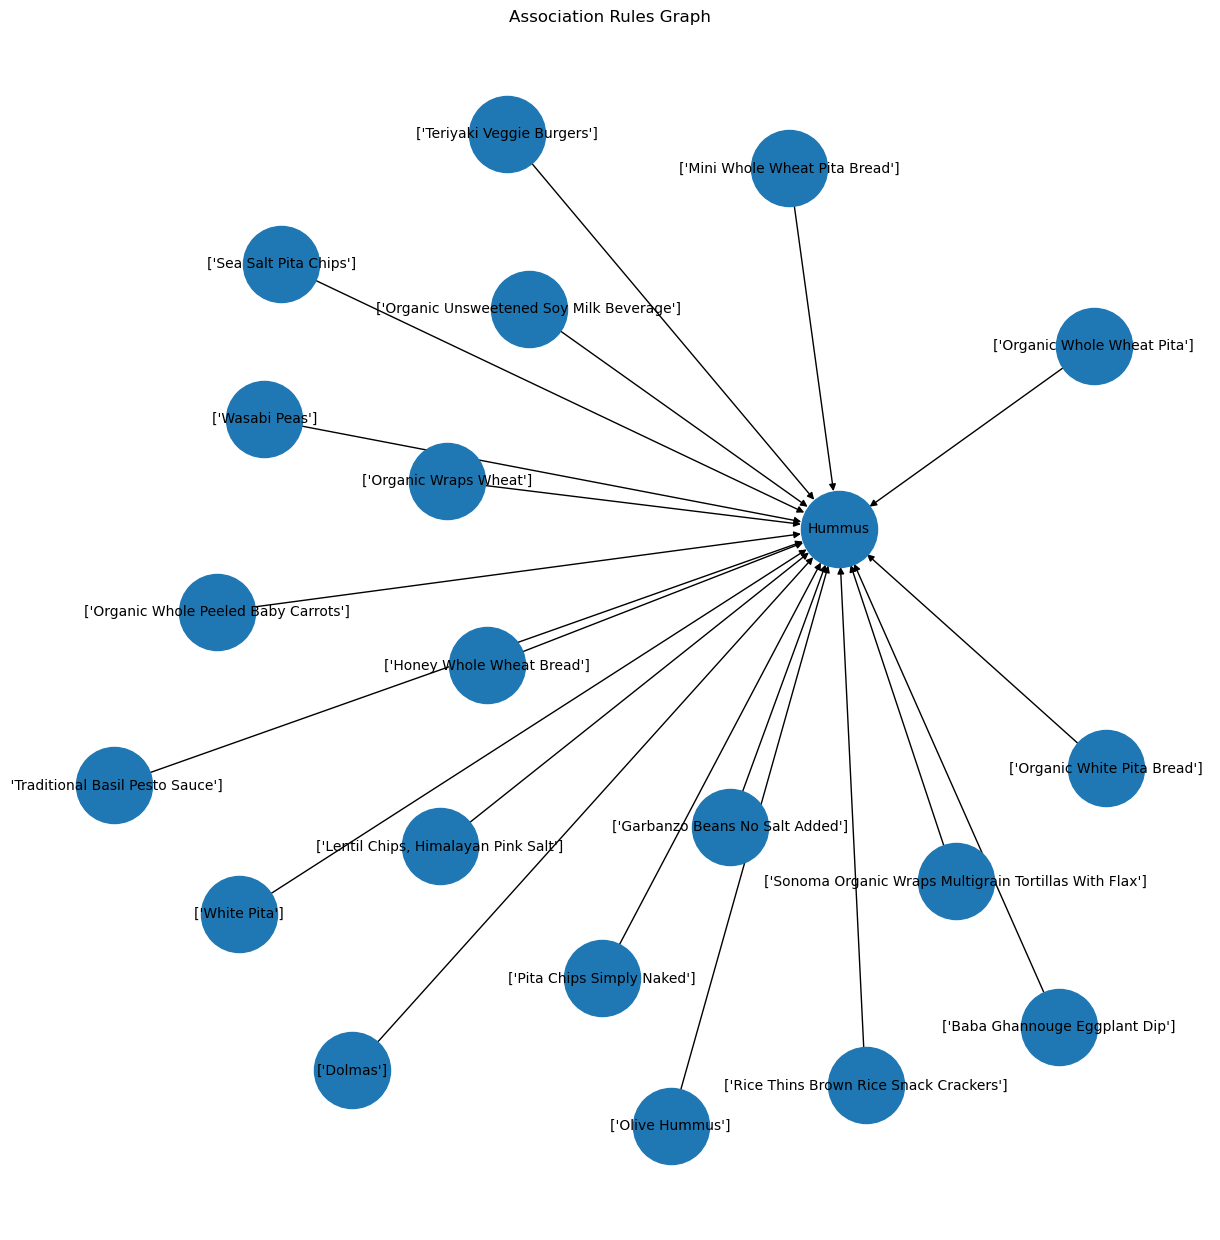

In [130]:
# Define graph_rules_subset, add the graph’s edges, and plot it. You may need a large figure size, smaller node size, and smaller font size.

graph_rules_subset = nx.MultiDiGraph()
graph_rules_subset.add_edges_from(
    # need to combine the column into tuples
    zip(df_rules_subset['antecedent_item'], df_rules_subset['consequent_item'])
)

# Then render the graph.
plt.figure(figsize=(12, 12)) 
nx.draw(graph_rules_subset, with_labels=True, node_size=3000, font_size=10, arrows=True)

plt.title('Association Rules Graph')
plt.show()

What can you tell about people who buy hummus?

They also buy chips or in general, grains to eat with it

## Make a Prediction

Given that the basket of items contains the following items, use the full set of association rules to predict the next 20 most likely items (consequents) that the person will add to the basket in descending order of lift:

* `'Orange Bell Pepper'`
* `'Organic Red Bell Pepper'`

Hint: a single item in the basket may be a better predictor of some consequents than both items considered together. You must consider both or either, but not neither.

In [131]:
basket = {'Orange Bell Pepper', 'Organic Red Bell Pepper'}


# Lamba functions used for lists in the antecedent items col
condition_1 = df_rules['antecedent_items'].apply(lambda x: 'Orange Bell Pepper' in x)
condition_2 = df_rules['antecedent_items'].apply(lambda x: 'Organic Red Bell Pepper' in x)


df_rules[# A few conditions go here which takes care of all the following cases:
         # * Just Orange Bell Pepper
         # * Just Organic Red Bell Pepper
         # * Both Orange Bell Pepper and Organic Red Bell Pepper
         # You can do it using just 2 conditions. :)
         condition_1 | condition_2
         ] \
        .sort_values('lift', ascending=False) \
        .head(20)


,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
346901,Non Fat Raspberry Yogurt,3346083,184,529,16953,[Icelandic Style Skyr Blueberry Non-fat Yogurt...,0.000055,0.347826,68.651858
349532,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,184,494,19962,"[Non Fat Raspberry Yogurt, Organic Red Bell Pe...",0.000055,0.372470,62.434341
350852,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,167,471,19962,"[Organic Red Bell Pepper, Vanilla Skyr Nonfat ...",0.000050,0.354565,59.433078
352283,Vanilla Skyr Nonfat Yogurt,3346083,167,529,18899,[Icelandic Style Skyr Blueberry Non-fat Yogurt...,0.000050,0.315690,55.893163
354421,Total 2% with Strawberry Lowfat Greek Strained...,3346083,235,502,30866,"[Organic Red Bell Pepper, Total 2% Lowfat Gree...",0.000070,0.468127,50.748184
355819,Organic Bell Pepper,3346083,145,420,24331,"[Organic Orange Bell Pepper, Organic Raspberri...",0.000043,0.345238,47.478333
356357,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,235,794,21405,"[Organic Red Bell Pepper, Total 2% with Strawb...",0.000070,0.295970,46.266733
356459,Yellow Bell Pepper,3346083,148,404,26625,"[85% Lean Ground Beef, Orange Bell Pepper]",0.000044,0.366337,46.039166
356643,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,160,548,21405,"[Orange Bell Pepper, Total 2% with Strawberry ...",0.000048,0.291971,45.641604
357451,Organic Bell Pepper,3346083,189,592,24331,"[Organic Orange Bell Pepper, Organic Red Bell ...",0.000056,0.319257,43.905290


## Bonus: Other Interesting Findings

Find and share something else interesting about these association rules. It can be a graph, table, or some other format that illustrates your point.